# Analysis of 1D Synthetic Data according to P-values

In [1]:
!python -m pip install multiple-hypothesis-testing

In [2]:
import numpy as np
import scipy
import math
import itertools
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from multitest import MultiTest

plt.rcParams['font.family'] = 'monospace'

# Utility Functions

In [3]:
def generate_multi_class_normal_population(sizes: list[int], mus: list[float], sigmas: list[float], seed: int = 0, uniform: bool = False, verbose: bool = False)\
        -> tuple[np.ndarray, np.ndarray] :
    if verbose:
        print(f'Generating multi class population: sizes={sizes}, mu={mus}, sigma={sigmas}')
    np.random.seed(seed=seed)
    z = []
    for size in sizes:
        if uniform:
            delta = 1/size
            x = np.linspace(start=delta/2, stop=1-delta/2, num=size)
            x = scipy.stats.norm.ppf(x)
        else:
            x = np.random.standard_normal(size=size)
        z.extend(list(x))
    z = np.array(z, dtype=np.float32)
    labels = np.array([label for ind,n in enumerate(sizes) for label in [ind]*n], dtype=int)
    mu_vector = np.array([mus[label] for label in labels], dtype=np.float32)
    std_vector = np.array([sigmas[label] for label in labels], dtype=np.float32)
    values = z * std_vector + mu_vector
    ind_premute = np.random.permutation(np.arange(len(labels)))
    return labels[ind_premute], values[ind_premute]


In [4]:
class Reject_Method:
    def __init__(self, name: str) -> None:
        self.name = name
        self.num_rejected = 0
        self.p_threshold = None
        self.p_curve = None
        self.f1_score_num_rejected = None
        self.acc2_score_num_rejected = None
        self.color = None
        self.mame_spaces = ''

    def str_summary(self):
        return self.name + self.name_spaces + f' #reject={self.num_rejected:3d} P_threshold={self.p_threshold:.4e} F1={self.f1_score_num_rejected:.2f} Acc2={self.acc2_score_num_rejected:.2f}'

    def complete_init(self, num: int, ind: int, max_len_name: int, f1_score_sorted: np.ndarray, acc2_score_sorted: np.ndarray):
        self.color = plt.cm.rainbow(ind/(num-1))
        self.name_spaces = ' ' * (max_len_name - len(self.name))
        self.f1_score_num_rejected = f1_score_sorted[self.num_rejected-1] if self.num_rejected > 0 else 0
        self.acc2_score_num_rejected = acc2_score_sorted[self.num_rejected-1] if self.num_rejected > 0 else 0


In [5]:

class HigherCriticism(Reject_Method):
    def __init__(self, p_values_sorted: np.ndarray, use_import: bool = True):
        super().__init__(name='Higher Criticism')
        if use_import:
            mtest = MultiTest(p_values_sorted)
            _, self.p_threshold = mtest.hc(gamma=0.3)
            self.objectives = mtest._zz
            self.num_rejected = np.sum(p_values_sorted <= self.p_threshold)
        else:
            N = int(p_values_sorted.size)
            i_N = np.arange(start=0.5,stop=N,step=1, dtype=np.float32) / N
            nominator = math.sqrt(N)*(i_N - p_values_sorted)
            denominator = np.sqrt(i_N*(1-i_N))
            zero_denom = denominator <= 1e-8 * np.abs(nominator)
            if zero_denom.any():
                ind_zero = zero_denom.argmax()  # first zero
                nominator = nominator[:ind_zero]
                denominator = denominator[:ind_zero]
            self.objectives = nominator / denominator
            sorted_objectives = self.objectives.argsort()[::-1]
            ind_lowest_objective = N - 1
            ind_best = N - 1
            best_beyond = 0
            for ind_objective in sorted_objectives:
                beyond_objective = ind_lowest_objective - ind_objective
                if beyond_objective >= best_beyond:
                    ind_best = ind_objective
                    best_beyond = beyond_objective
                ind_lowest_objective = min(ind_lowest_objective, ind_objective)
            self.p_threshold = p_values_sorted[ind_best]
            self.num_rejected = ind_best + 1
        self.p_curve = np.full_like(p_values_sorted, fill_value=self.p_threshold)


In [6]:
class Benjamini_Hochberg(Reject_Method):
    def __init__(self, p_values_sorted: np.ndarray, alpha: float = 0.05) -> None:
        super().__init__(name=f'Benjamini Hochberg alpha={alpha:.2f}')
        N = p_values_sorted.size
        arange = np.arange(1,N+1, dtype=int)
        self.p_curve = arange * alpha / N
        rejected_BH = p_values_sorted <= self.p_curve
        if rejected_BH.sum():
            self.num_rejected = arange[rejected_BH].max()
            self.p_threshold = self.p_curve[self.num_rejected - 1]
        else:
            self.num_rejected = 0
            self.p_threshold = self.p_curve[0]


In [7]:
class Bonferroni(Reject_Method):
    def __init__(self, p_values: np.ndarray, alpha: float) -> None:
        super().__init__(name=f'Bonferroni alpha={alpha:.2f}')
        N = len(p_values)
        self.p_threshold = alpha/N
        self.num_rejected = np.sum(p_values <= self.p_threshold)
        self.p_curve = np.full_like(p_values, fill_value=self.p_threshold)

In [8]:
class GMM_Thresholding(Reject_Method):
    def __init__(self, Z_scores: np.ndarray, p_values_sorted: np.ndarray, seed: int = 0) -> None:
        super().__init__(name='GMM')
        gmm_input = Z_scores.reshape(-1, 1)
        gmm = GaussianMixture(n_components=2, random_state=seed).fit(gmm_input)
        self.predictions = gmm.predict(gmm_input).astype(int)
        if self.predictions.min() == 1:
            self.predictions[:] = 0
            self.z_threshold = np.inf
        elif self.predictions.max() == 0:
            self.z_threshold = np.inf
        else:
            if Z_scores[self.predictions == 0].mean() > Z_scores[self.predictions == 1].mean():
                self.predictions = 1 - self.predictions
            self.z_threshold = Z_scores[self.predictions == 1].min()
            if self.z_threshold < Z_scores[self.predictions == 0].max():
                self.predictions[Z_scores >= self.z_threshold] = 1
                self.predictions[Z_scores < self.z_threshold] = 0
        self.num_rejected = self.predictions.sum()
        self.p_threshold = p_values_sorted[max(self.num_rejected - 1, 0)]
        self.p_curve = np.full_like(p_values_sorted, fill_value=self.p_threshold)


In [9]:
class Maximal_Score(Reject_Method):
    def __init__(self, name: str, p_values_sorted: np.ndarray, score_sorted: np.ndarray) -> None:
        super().__init__(name=name)
        ind_best = np.argmax(score_sorted)
        self.num_rejected = ind_best + 1
        self.p_threshold = p_values_sorted[ind_best]
        self.p_curve = np.full_like(p_values_sorted, fill_value=self.p_threshold)

In [10]:
class Alpha_Rejection(Reject_Method):
    def __init__(self, p_values_sorted: np.ndarray, alpha: float) -> None:
        super().__init__(name=f'alpha={alpha:.2f}')
        self.num_rejected = np.sum(p_values_sorted <= alpha)
        self.p_threshold = alpha
        self.p_curve = np.full_like(p_values_sorted, fill_value=self.p_threshold)

In [11]:
def sorted_f1_score(labels: np.ndarray, sorted_indexes: np.ndarray) -> np.ndarray:
    N = len(labels)
    topK_predictions = np.zeros_like(labels)
    ret = np.empty(shape=N, dtype=np.float32)
    for ind_sort in range(N):
        topK_predictions[sorted_indexes[ind_sort]] = 1
        ret[ind_sort] = metrics.f1_score(y_true=labels, y_pred=topK_predictions)
    return ret


In [12]:
def sorted_acc2_score(labels: np.ndarray, sorted_indexes: np.ndarray) -> np.ndarray:
    N = len(labels)
    topK_predictions = np.zeros_like(labels)
    ret = np.empty(shape=N, dtype=np.float32)
    sum_positive = labels.sum()
    sum_negative = N - sum_positive
    true_factor = 1/(sum_positive*sum_negative)
    for ind_sort in range(N):
        topK_predictions[sorted_indexes[ind_sort]] = 1
        true_positive = np.sum((topK_predictions == 1) & (labels == 1))
        true_negative = np.sum((topK_predictions == 0) & (labels == 0))
        ret[ind_sort] = true_positive*true_negative
    return np.sqrt(ret*true_factor)

# Main Class

In [13]:
class DataCreator:
    def __init__(self, N: int = 1000, rarity: float = 1, mu: float = 1, alpha: float = 0.05, p_value_sides: int = 1, uniform: bool = False, seed: int = 0):
        assert p_value_sides in [1, 2]
        assert 0 < rarity
        assert 0 < alpha < 1
        assert N > 10
        self.N = N
        self.rarity = rarity
        self.mu = mu
        self.alpha = alpha
        self.num_non_zeros = max(1, int(N* (10**(-rarity))))
        self.num_zeros = self.N - self.num_non_zeros
        self.str_ratio = f'Ratio Non Zeros = {self.num_non_zeros/N*100:.2f}%'
        self.labels, self.X = generate_multi_class_normal_population([self.num_zeros, self.num_non_zeros], [0, mu], [1, 1], uniform=uniform, seed=seed)
        self.p_value_sides = p_value_sides
        if p_value_sides == 1:
            self.Z_score = self.X  # (self.X - self.X.mean())/self.X.std()
            self.p_values = scipy.stats.norm.sf(self.Z_score)  # one-sided
            self.p_value_sides_str = 'one-sided'
        else:
            self.Z_score = np.abs(self.X)  # (self.X - self.X.mean())/self.X.std()
            self.p_values = scipy.stats.norm.sf(self.Z_score) * 2  # two-sided
            self.p_value_sides_str = 'two-sided'
        self.original_ID = np.arange(1, self.N+1, dtype=int)
        self.sorted_indexes = self.p_values.argsort()
        self.sorted_labels = self.labels[self.sorted_indexes]
        self.Z_score_sorted = self.Z_score[self.sorted_indexes]
        self.p_values_sorted = self.p_values[self.sorted_indexes]
        self.f1_score_sorted = sorted_f1_score(self.labels, self.sorted_indexes)
        self.acc2_score_sorted = sorted_acc2_score(self.labels, self.sorted_indexes)
        self.higher_criticism = HigherCriticism(self.p_values_sorted, use_import=False)
        self.GMM_Thresholding = GMM_Thresholding(self.Z_score, p_values_sorted=self.p_values_sorted, seed=seed)
        self.Benjamini_Hochberg = Benjamini_Hochberg(p_values_sorted=self.p_values_sorted, alpha=self.alpha)
        self.Bonferroni = Bonferroni(p_values=self.p_values_sorted, alpha=alpha)
        self.Optimal_F1 = Maximal_Score(name='Optimal F1 score', p_values_sorted=self.p_values_sorted, score_sorted=self.f1_score_sorted)
        self.Optimal_Acc2 = Maximal_Score(name='Optimal Acc2 score', p_values_sorted=self.p_values_sorted, score_sorted=self.acc2_score_sorted)
        self.alpha_rejection = Alpha_Rejection(p_values_sorted=self.p_values_sorted, alpha=self.alpha)
        self.non_optimal_methods = [self.higher_criticism, self.Benjamini_Hochberg, self.GMM_Thresholding, self.Bonferroni, self.alpha_rejection]
        self.optimal_methods = [self.Optimal_F1, self.Optimal_Acc2]
        self.all_methods = self.non_optimal_methods + self.optimal_methods
        methods_name_len = max([len(m.name) for m in self.all_methods])
        for ind,method in enumerate(self.all_methods):
            method.complete_init(num=len(self.all_methods),ind=ind,max_len_name=methods_name_len,
                                 f1_score_sorted=self.f1_score_sorted,acc2_score_sorted=self.acc2_score_sorted)
        self.min_x = self.X.min()
        self.max_x = self.X.max()
        self.color0 = 'blue'
        self.color1 = 'red'
        self.label0 = f'Group mu= 0    '
        self.label1 = f'Group mu= {self.mu:.2f}'

    def ListedColormap(self, num_methods: int):
        return mpl.colors.ListedColormap([m.color for m in self.all_methods[:num_methods]])

    def original_scatter(self):
        plt.figure(figsize=(20,10))
        plt.title(label=f'Original Data\n#Samples={self.N}  rarity={self.rarity:.2f} mu={self.mu:.2f}\n{self.str_ratio}')
        plt.scatter(x=self.original_ID[self.labels == 0], y=self.X[self.labels == 0], color=self.color0, label=self.label0)
        plt.scatter(x=self.original_ID[self.labels == 1], y=self.X[self.labels == 1], color=self.color1, label=self.label1)
        plt.xlabel(xlabel='Sample ID')
        plt.ylabel(ylabel='Sample Value')
        plt.legend()
        plt.show()

    def histogram(self):
        bins = int(self.X.size**0.5 + 0.01)
        plt.figure(figsize=(10,8))
        plt.title(label=f'Original Data Histogram Density {bins} bins')
        plt.hist(self.X, bins=bins, density=True, label='Histogram Density')
        x = np.linspace(-3, +3, 100)
        plt.plot(x, scipy.stats.norm.pdf(x, 0, 1), label=f'Standard Normal Distribution')
        plt.xlabel(xlabel='Sample Value')
        plt.ylabel(ylabel='Sample Density')
        plt.legend()
        plt.show()

    def sorted_bar_chart(self):
        select_group_0_from_sorted = self.sorted_labels == 0
        select_group_1_from_sorted = self.sorted_labels == 1
        plt.figure(figsize=(20,10))
        plt.title(label=f'Sorted Z-score Bar Chart. Based on {self.p_value_sides_str} analysis')
        plt.bar(x=self.original_ID[select_group_0_from_sorted], height=self.Z_score_sorted[select_group_0_from_sorted], color=self.color0, label=self.label0)
        plt.bar(x=self.original_ID[select_group_1_from_sorted], height=self.Z_score_sorted[select_group_1_from_sorted], color=self.color1, label=self.label1)
        plt.xlabel(xlabel='Sorted Samples by P-value')
        plt.ylabel(ylabel='Sample Value')
        plt.legend()
        plt.show()

    def p_values_FDR_chart(self):
        min_p = self.p_values_sorted.min()
        for y_scale in ['linear', 'log']:
            plt.figure(figsize=(20,10))
            plt.title(label=f'Sorted {self.p_value_sides_str} P-values ({y_scale} scale). Minimum P-value={min_p:.4e}')
            plt.yscale(y_scale)
            self.sorted_scatter(x=self.original_ID, y=self.p_values_sorted)
            for method in self.all_methods:
                plt.plot(self.original_ID, method.p_curve, label=method.str_summary(), c=method.color)
            plt.xlabel(xlabel='Sorted Samples by P-value')
            plt.ylabel(ylabel='Sample P-value')
            plt.legend()
            plt.show()

    def plot_HC_objectives(self):
        hc_objectives = self.higher_criticism.objectives
        HC_best_ID = self.higher_criticism.num_rejected
        plt.figure(figsize=(20,10))
        plt.title(label='Higher Criticism objectives values')
        plt.plot(self.original_ID[:len(hc_objectives)], hc_objectives, label='HC objectives')
        plt.vlines(x=HC_best_ID, ymin=hc_objectives.min(), ymax=hc_objectives.max(), label=f'Optimal HC rejects {HC_best_ID}', linestyles='dashed',
                   colors='red')
        plt.xlabel(xlabel='Sorted Samples by P-value')
        plt.ylabel(ylabel='HC values')
        plt.legend()
        plt.show()

    def ROC_Curve(self):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        metrics.RocCurveDisplay.from_predictions(ax=ax, y_true=self.sorted_labels, y_pred=1-self.p_values_sorted)
        ax.set_title(f'ROC Curve as a function of alpha')
        plt.legend()
        plt.show()

    def gmm_scatter(self):
        self.predictions_scatter(name='GMM', predictions=self.GMM_Thresholding.predictions)

    def hc_scatter(self):
        hc_predictions = np.zeros_like(self.labels)
        hc_predictions[self.sorted_indexes[:self.higher_criticism.num_rejected]] = 1
        self.predictions_scatter(name='Higher Criticism', predictions=hc_predictions)

    def plot_f1_sorted_score(self):
        self.plot_sorted_score(y_label='F1 score', sorted_score=self.f1_score_sorted)

    def plot_acc2_sorted_score(self):
        self.plot_sorted_score(y_label='Acc2 score', sorted_score=self.acc2_score_sorted)

    def plot_sorted_score(self, y_label: str, sorted_score: np.ndarray):
        x_label = f'topK'
        plt.figure(figsize=(20,10))
        plt.title(label=f'{y_label} as a function of {x_label}')
        self.sorted_scatter(x=self.original_ID, y=sorted_score)
        y_max = min(1, sorted_score.max()*2)
        for method in self.all_methods:
            plt.vlines(x=method.num_rejected, ymin=0, ymax=1, label=method.str_summary(), linestyles='dashed', colors=method.color)
        plt.xlabel(xlabel=x_label)
        plt.ylabel(ylabel=y_label)
        plt.xlim(xmin=int(-0.01*self.N), xmax=int(1.01*self.N))
        plt.ylim(ymin=0.0, ymax=y_max)
        plt.legend()
        plt.show()

        x_label = f'{self.p_value_sides_str} P-value'
        plt.figure(figsize=(20,10))
        plt.title(label=f'{y_label} as a function of {x_label}')
        self.sorted_scatter(x=self.p_values_sorted, y=sorted_score)
        for method in self.all_methods:
            plt.vlines(x=method.p_threshold, ymin=0, ymax=1, label=method.str_summary(), linestyles='dashed', colors=method.color)
        plt.xlabel(xlabel=x_label)
        plt.ylabel(ylabel=y_label)
        plt.xlim(xmin=-0.01, xmax=1.01)
        plt.ylim(ymin=0.0, ymax=y_max)
        plt.legend()
        plt.show()


    def predictions_scatter(self, name: str, predictions: np.ndarray):
        assert predictions.shape == self.labels.shape
        assert predictions.min() >= self.labels.min()
        assert predictions.max() <= self.labels.max()
        plt.figure(figsize=(20,10))
        pred_f1 = metrics.f1_score(y_true=self.labels, y_pred=predictions)
        plt.title(label=f'{name} Predictions. F1_score={pred_f1:.4f}')
        true_positive = (predictions == 1) & (self.labels == 1)
        false_positive = (predictions == 1) & (self.labels == 0)
        true_negative = (predictions == 0) & (self.labels == 0)
        false_negative = (predictions == 0) & (self.labels == 1)
        def plt_scatter(boolean_selection: np.ndarray, color: str, marker: str, label: str):
            plt.scatter(x=self.original_ID[boolean_selection], y=self.X[boolean_selection], color=color, marker=marker,
                        label=label + f' ratio={boolean_selection.sum()/self.N*100:.2f}%')
        plt_scatter(true_negative, color=self.color0, marker='o', label='True ' + self.label0)
        plt_scatter(true_positive, color=self.color1, marker='o', label='True ' + self.label1)
        plt_scatter(false_negative, color=self.color1, marker='X', label='False ' + self.label0)
        plt_scatter(false_positive, color=self.color0, marker='X', label='False ' + self.label1)
        min_prediction_positive = self.Z_score[predictions == 1].min()
        max_prediction_negative = self.Z_score[predictions == 0].max()
        if min_prediction_positive > max_prediction_negative:
            threshold = 0.5*(min_prediction_positive+max_prediction_negative)
            plt.hlines(y=threshold, xmin=1, xmax=self.N, linestyles='dashed', label=f'{name} threshold = {threshold:.2f}')
        plt.xlabel(xlabel='Sample ID')
        plt.ylabel(ylabel='Sample Value')
        plt.legend()
        plt.show()

    def sorted_scatter(self, x, y):
        select_group_0_from_sorted = self.sorted_labels == 0
        select_group_1_from_sorted = self.sorted_labels == 1
        plt.scatter(x=x[select_group_0_from_sorted], y=y[select_group_0_from_sorted], color=self.color0, label=self.label0)
        plt.scatter(x=x[select_group_1_from_sorted], y=y[select_group_1_from_sorted], color=self.color1, label=self.label1)


# Original dataset exploration

In [14]:
data = DataCreator(N=1000, mu=2, rarity=2)

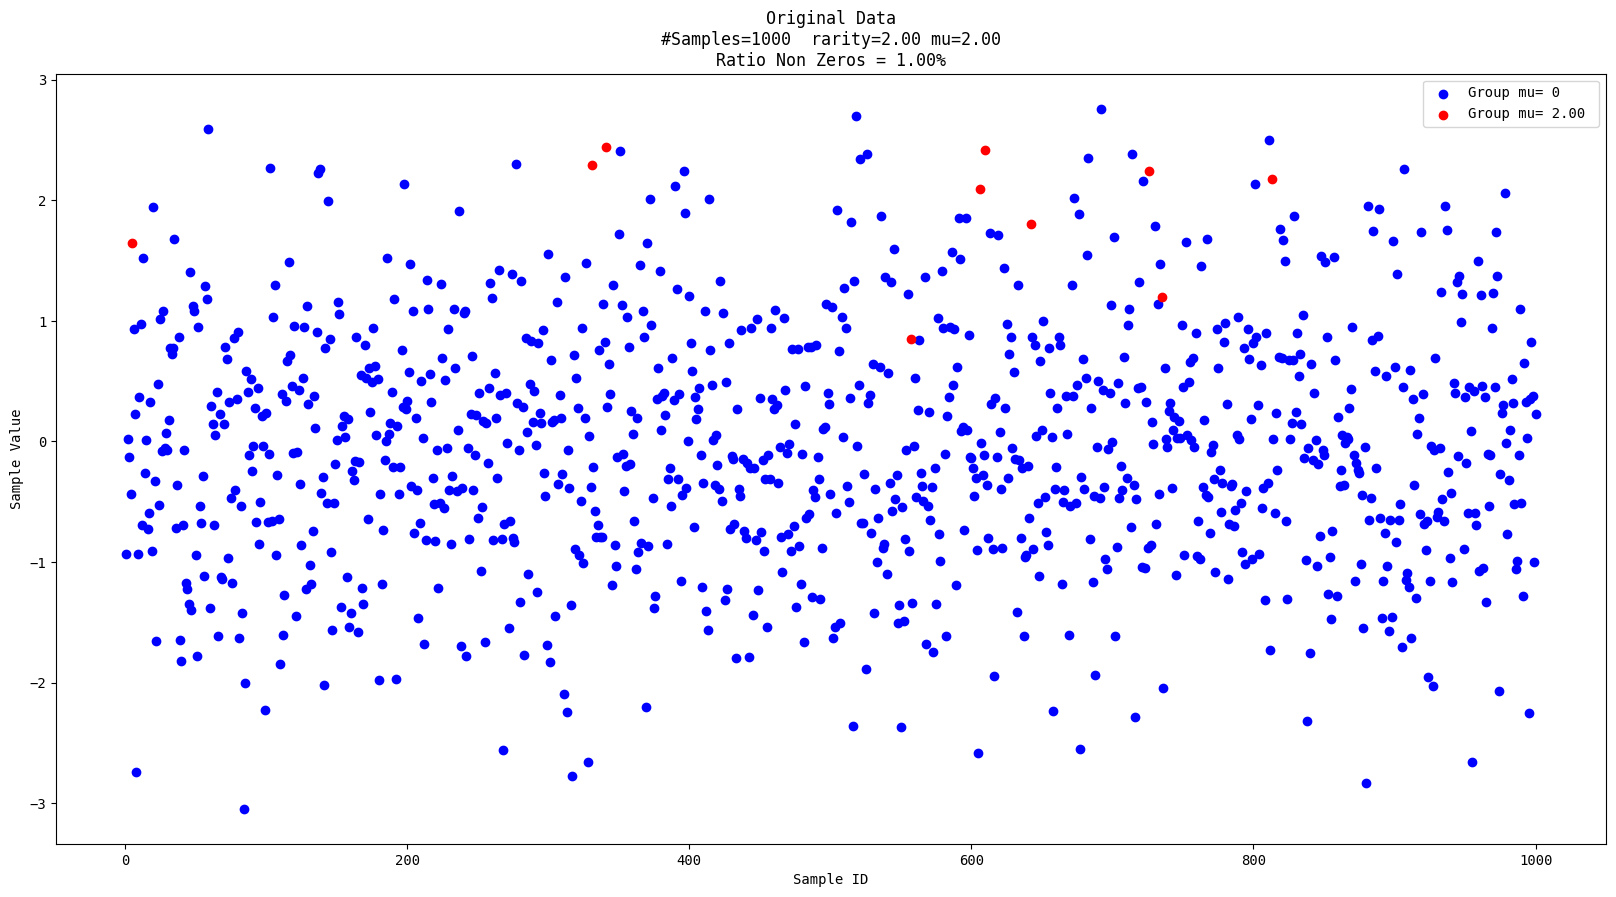

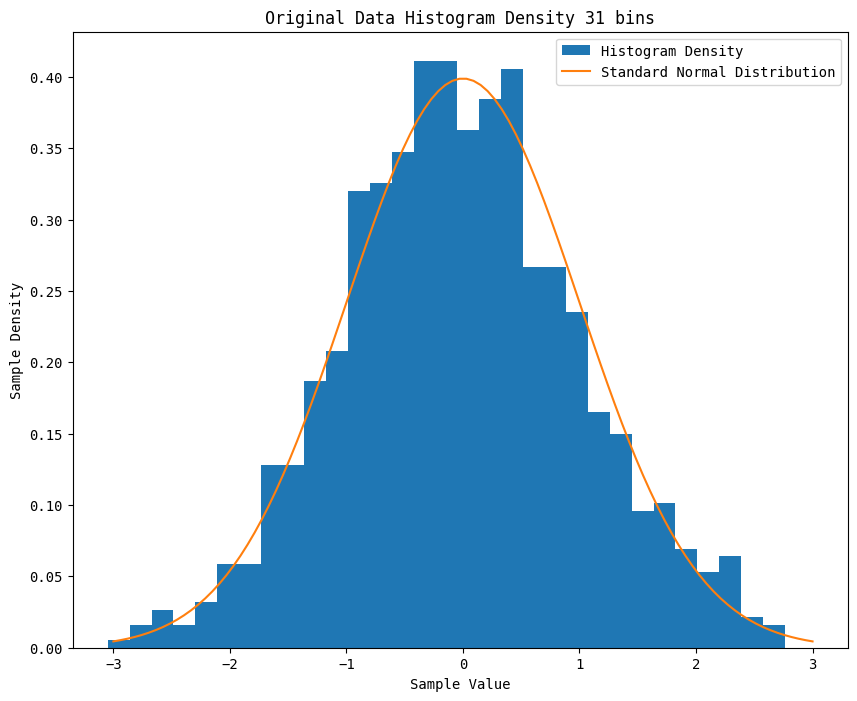

In [15]:
data.original_scatter()
data.histogram()

# Sorting according to P-values

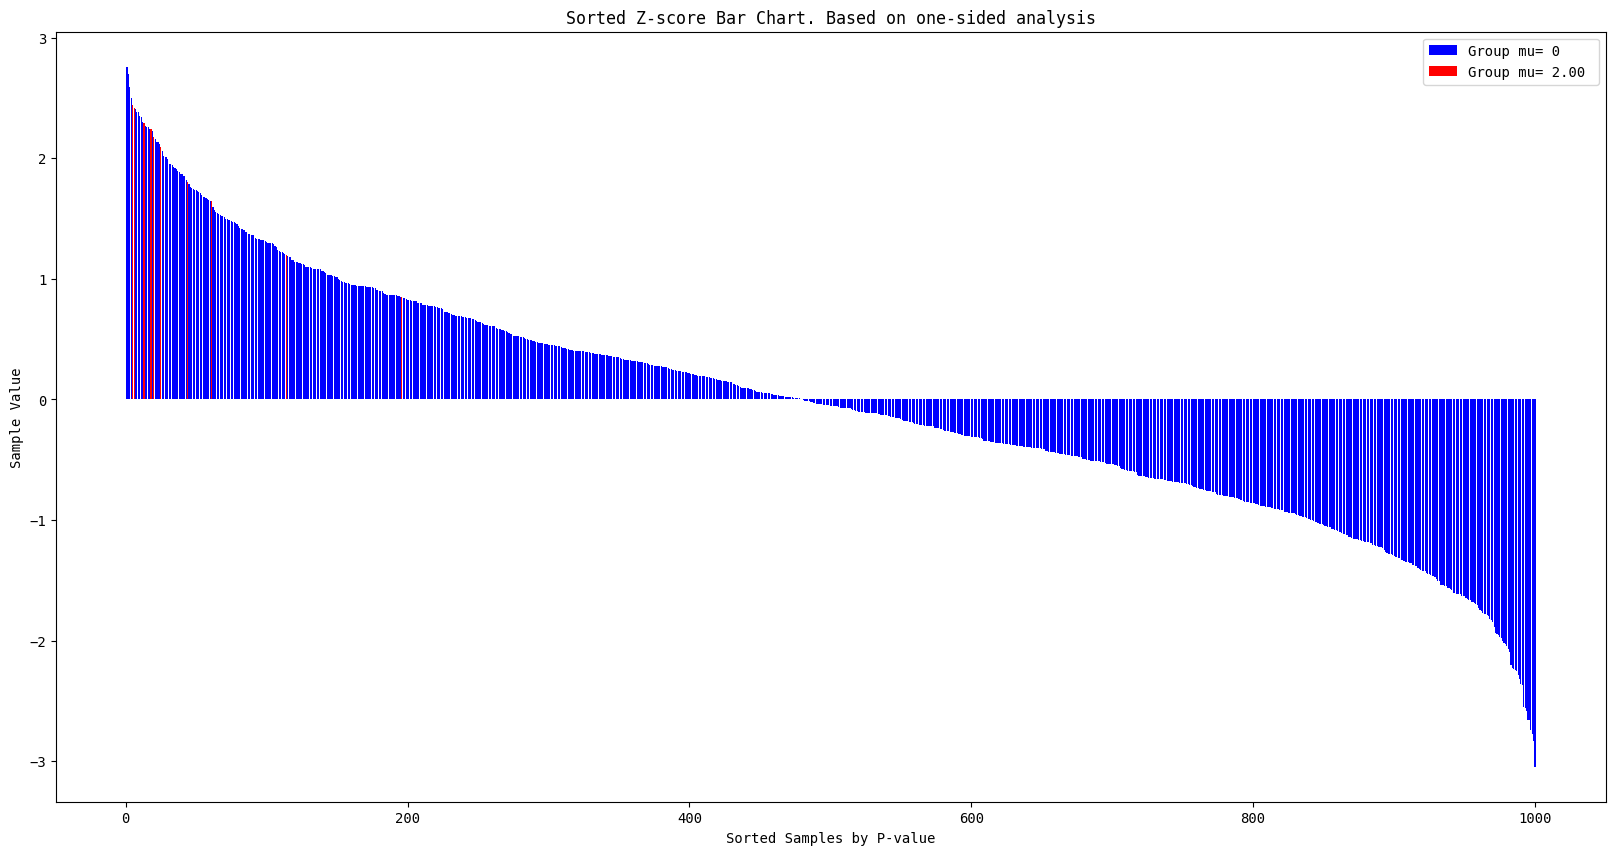

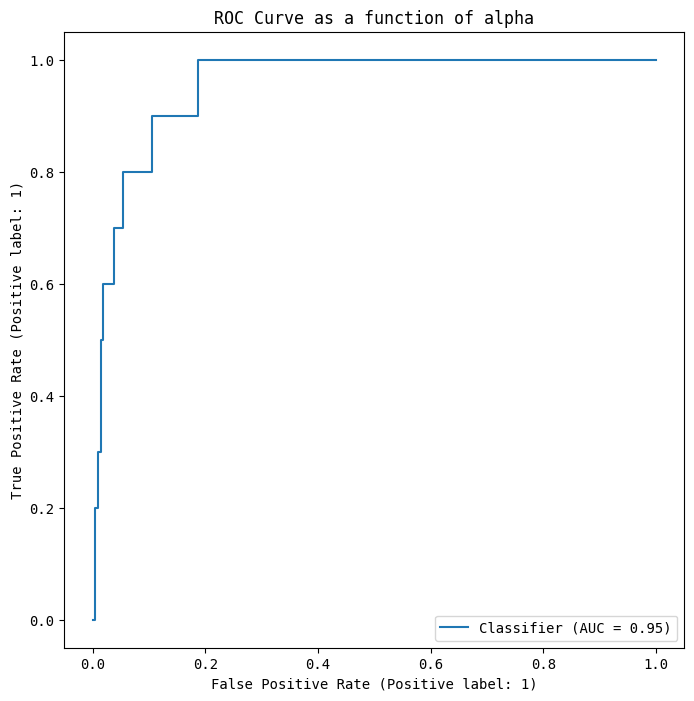

In [16]:
data.sorted_bar_chart()
data.ROC_Curve()

# Rejecting Multi Null Hypothesis

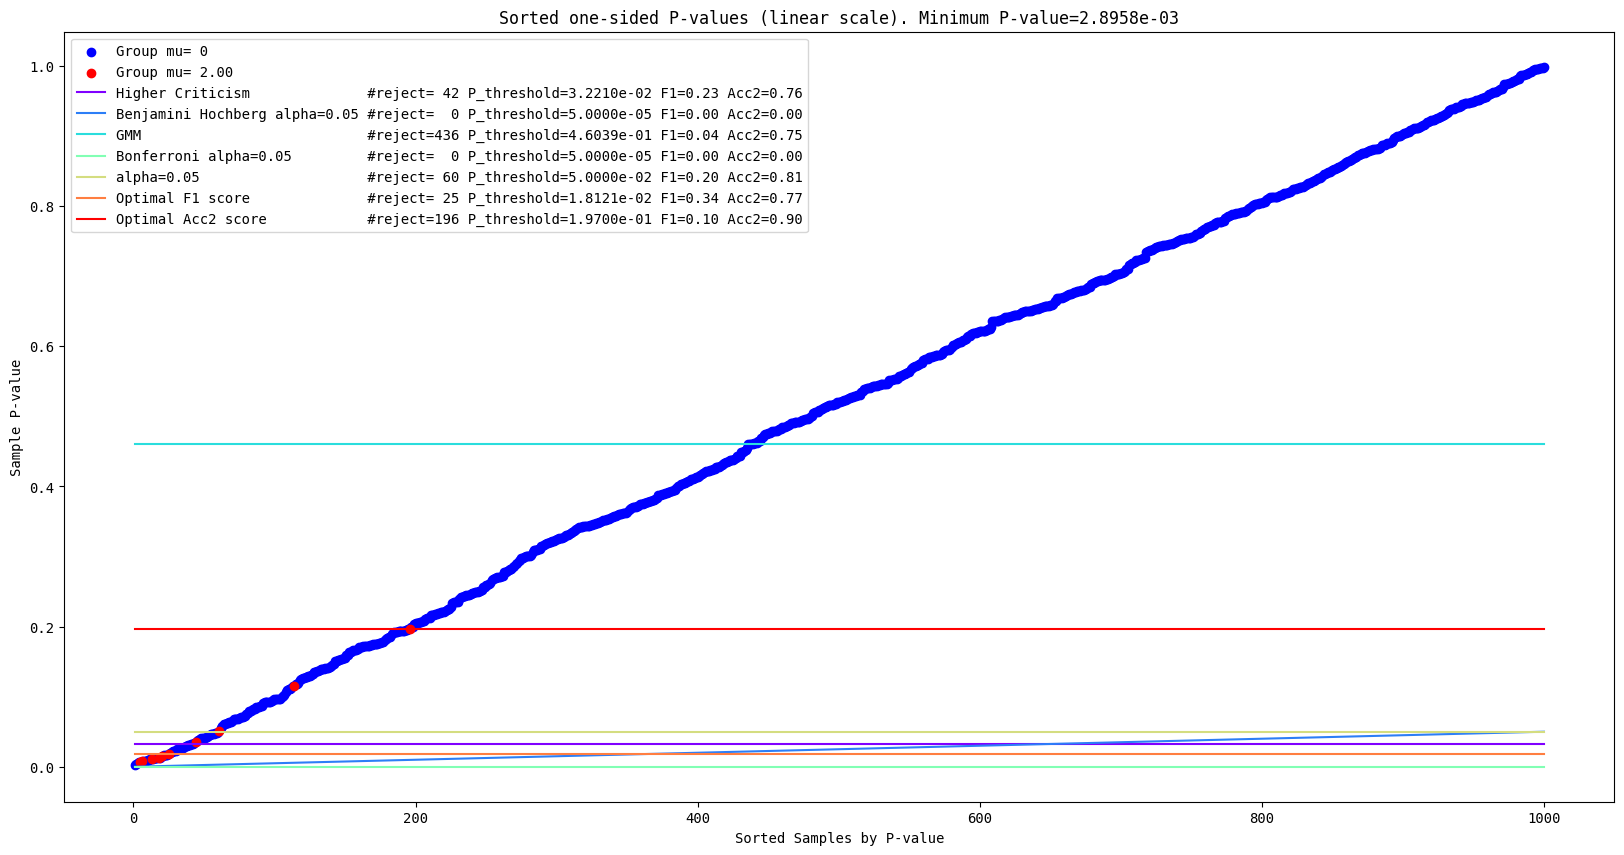

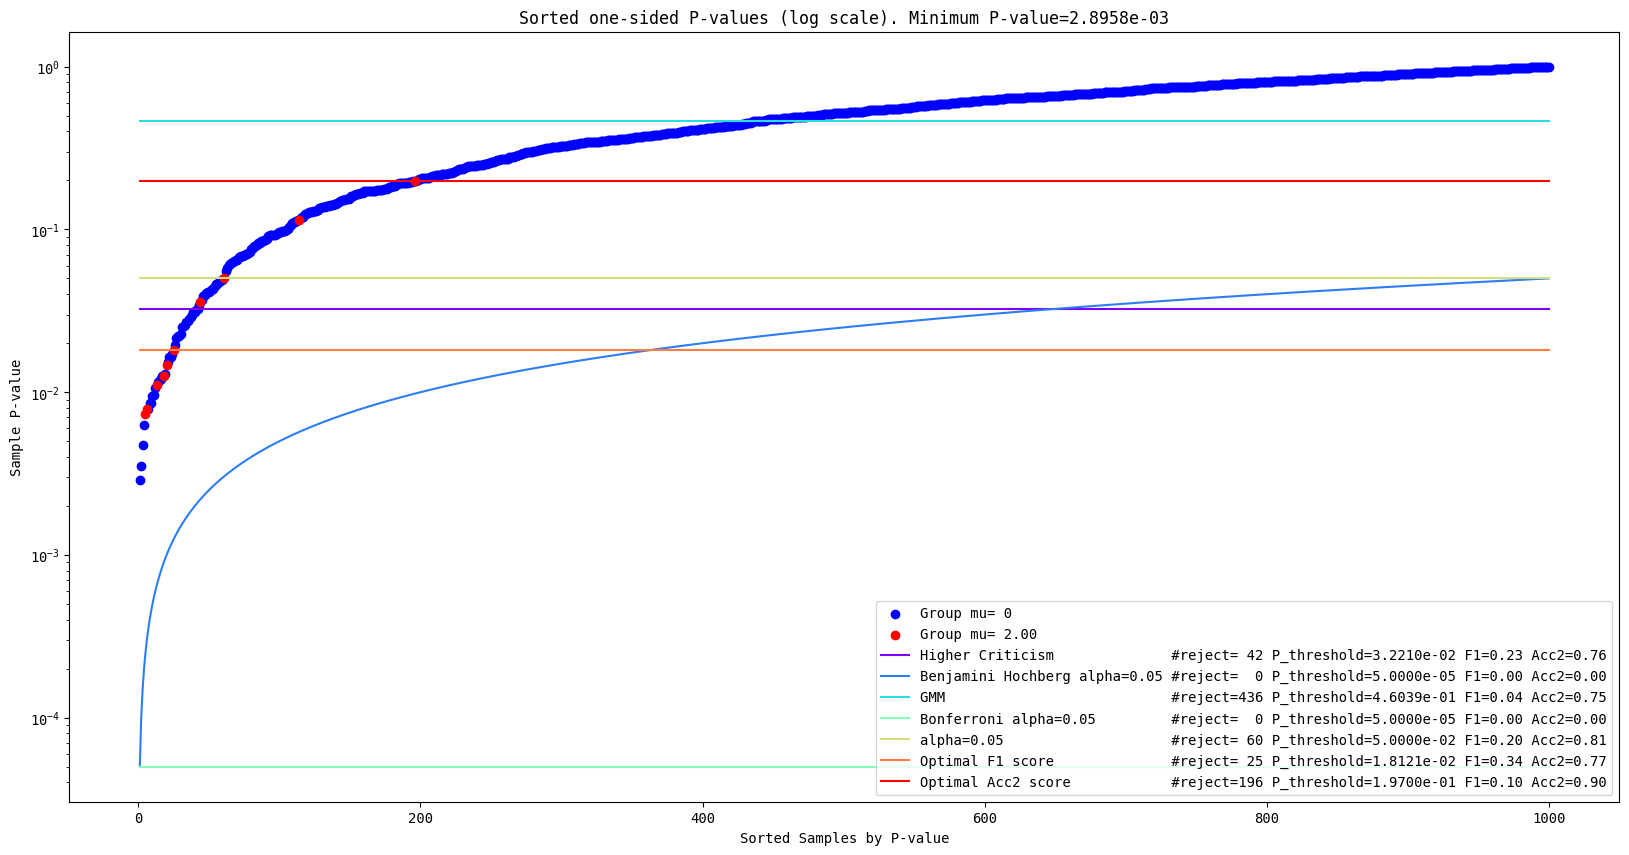

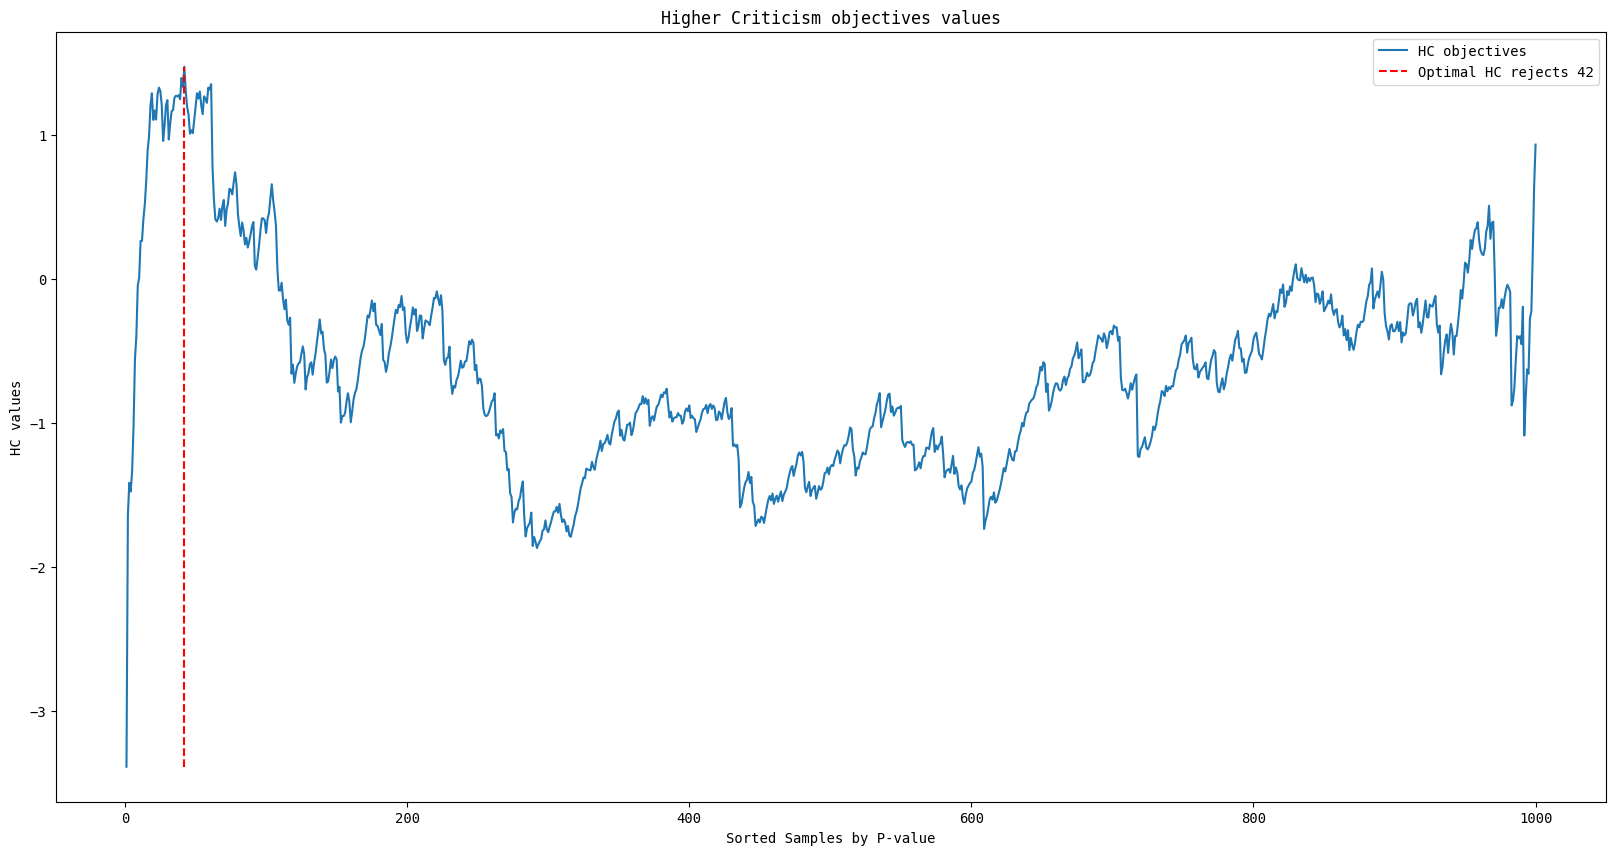

In [17]:
data.p_values_FDR_chart()
data.plot_HC_objectives()

# Classifications

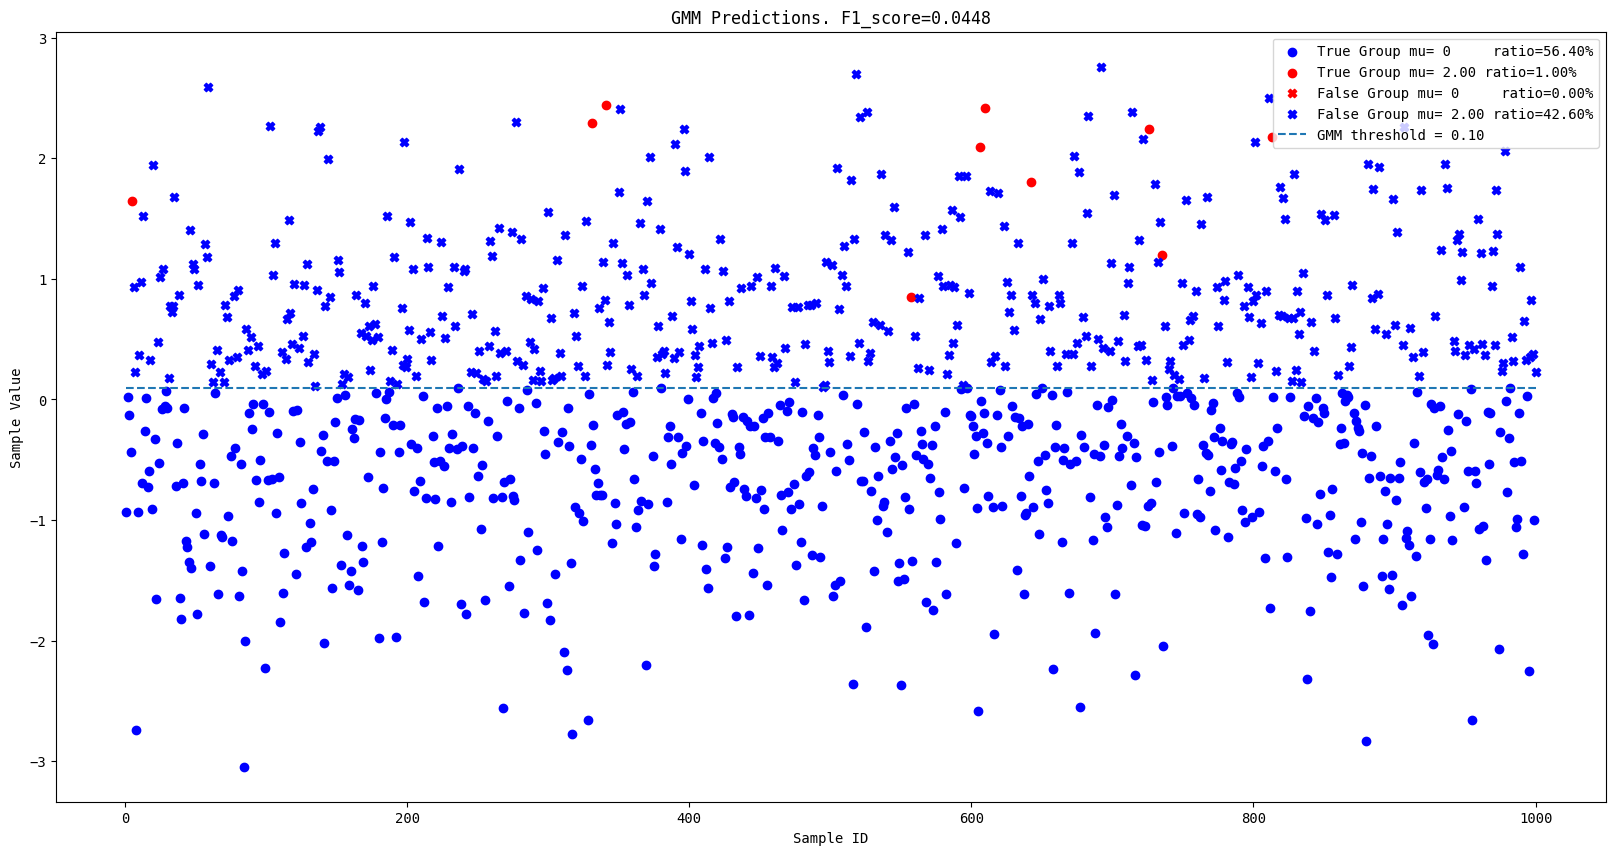

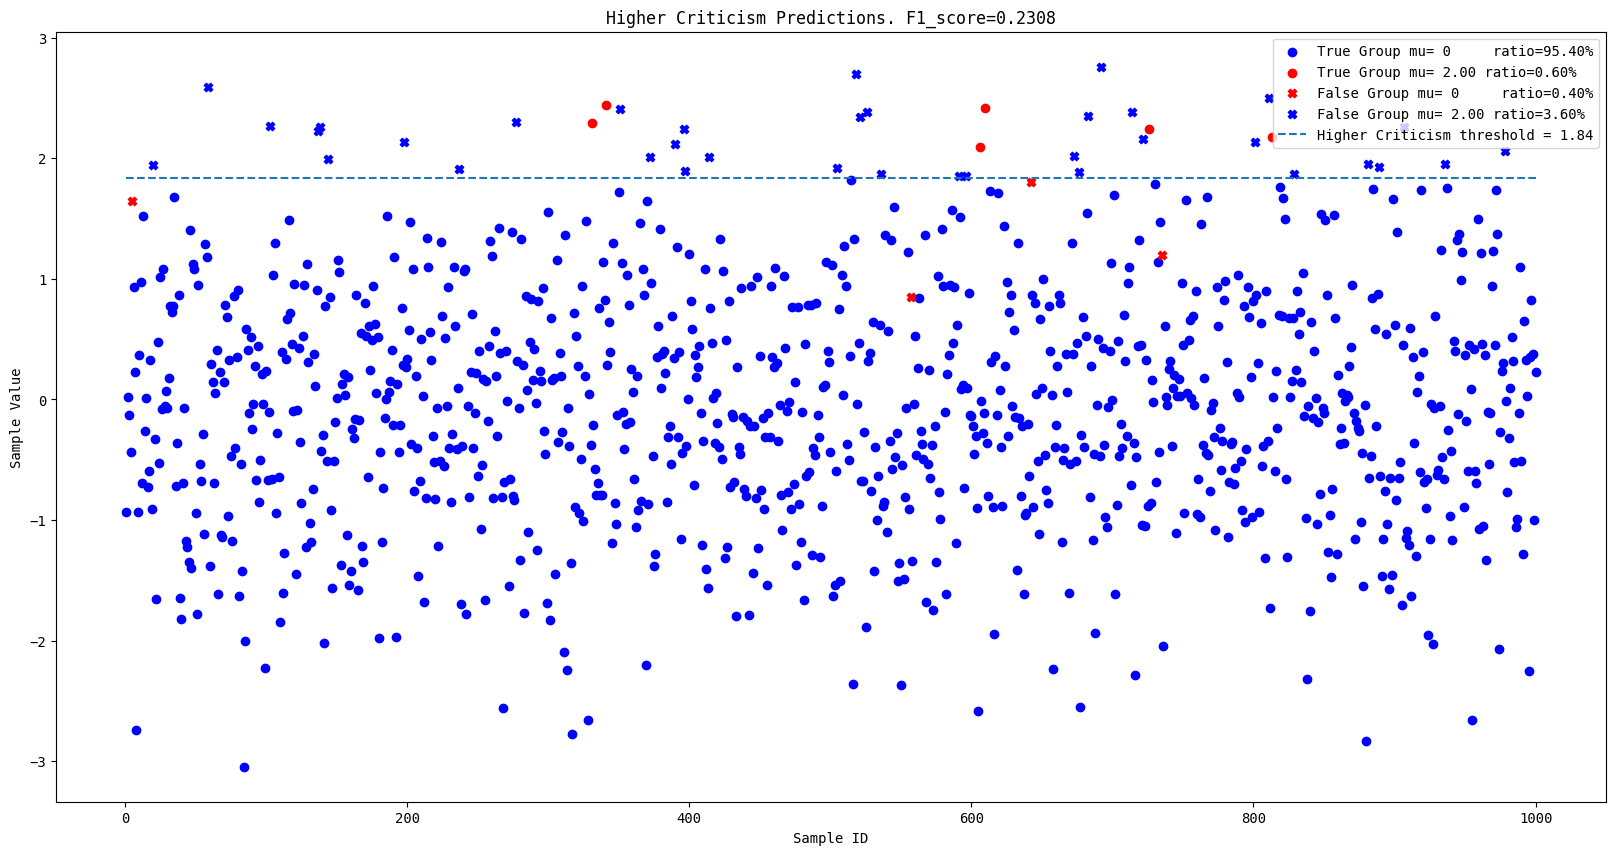

In [18]:
#
data.gmm_scatter()
data.hc_scatter()

# Optimization of sorted score

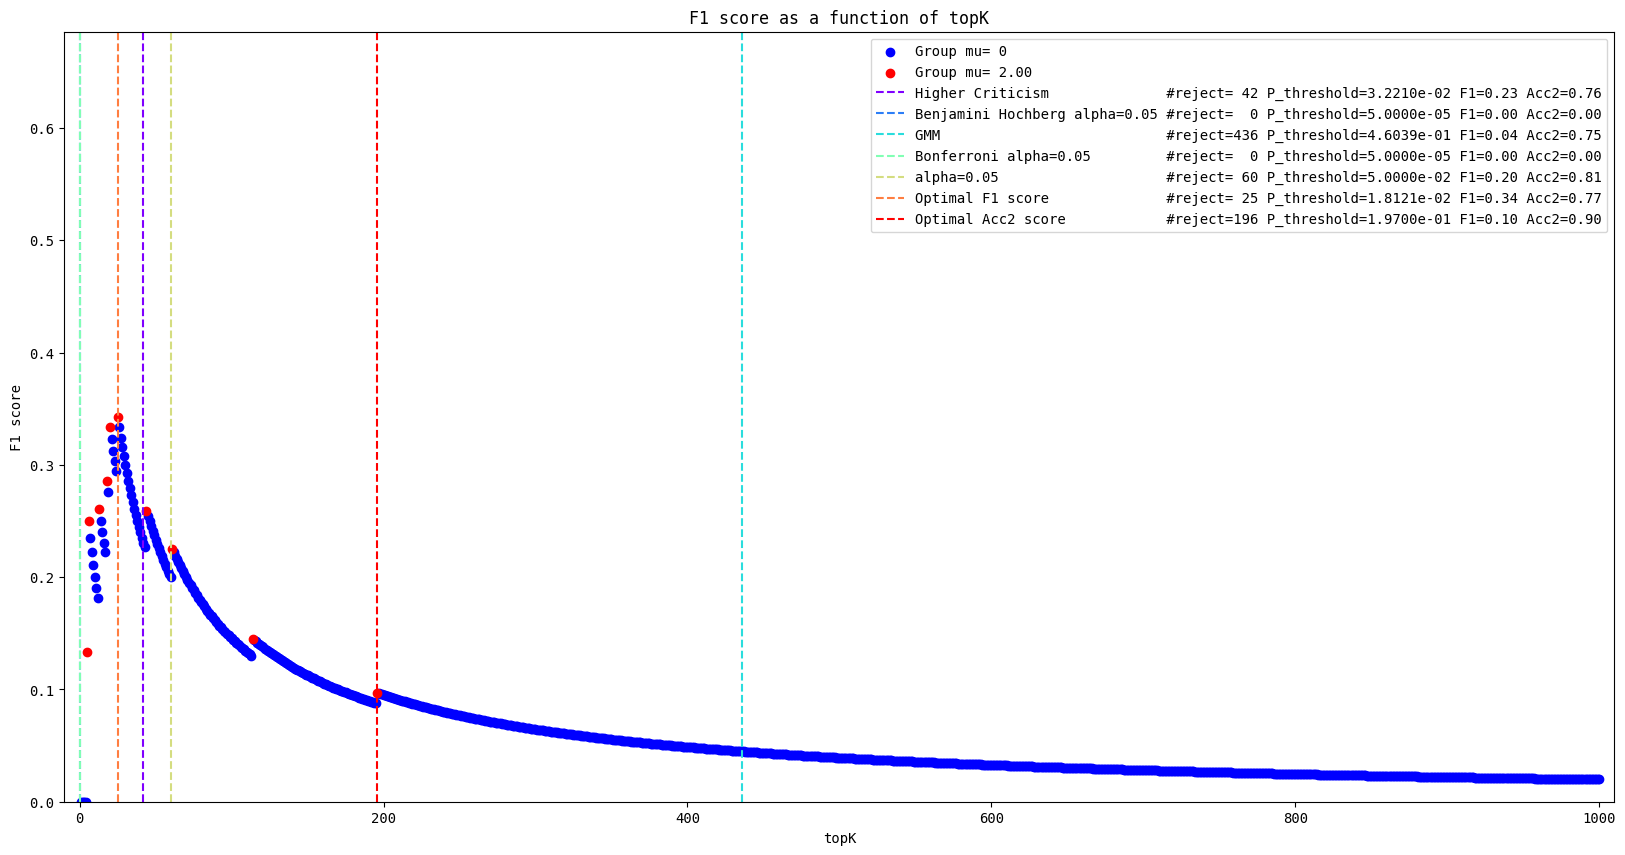

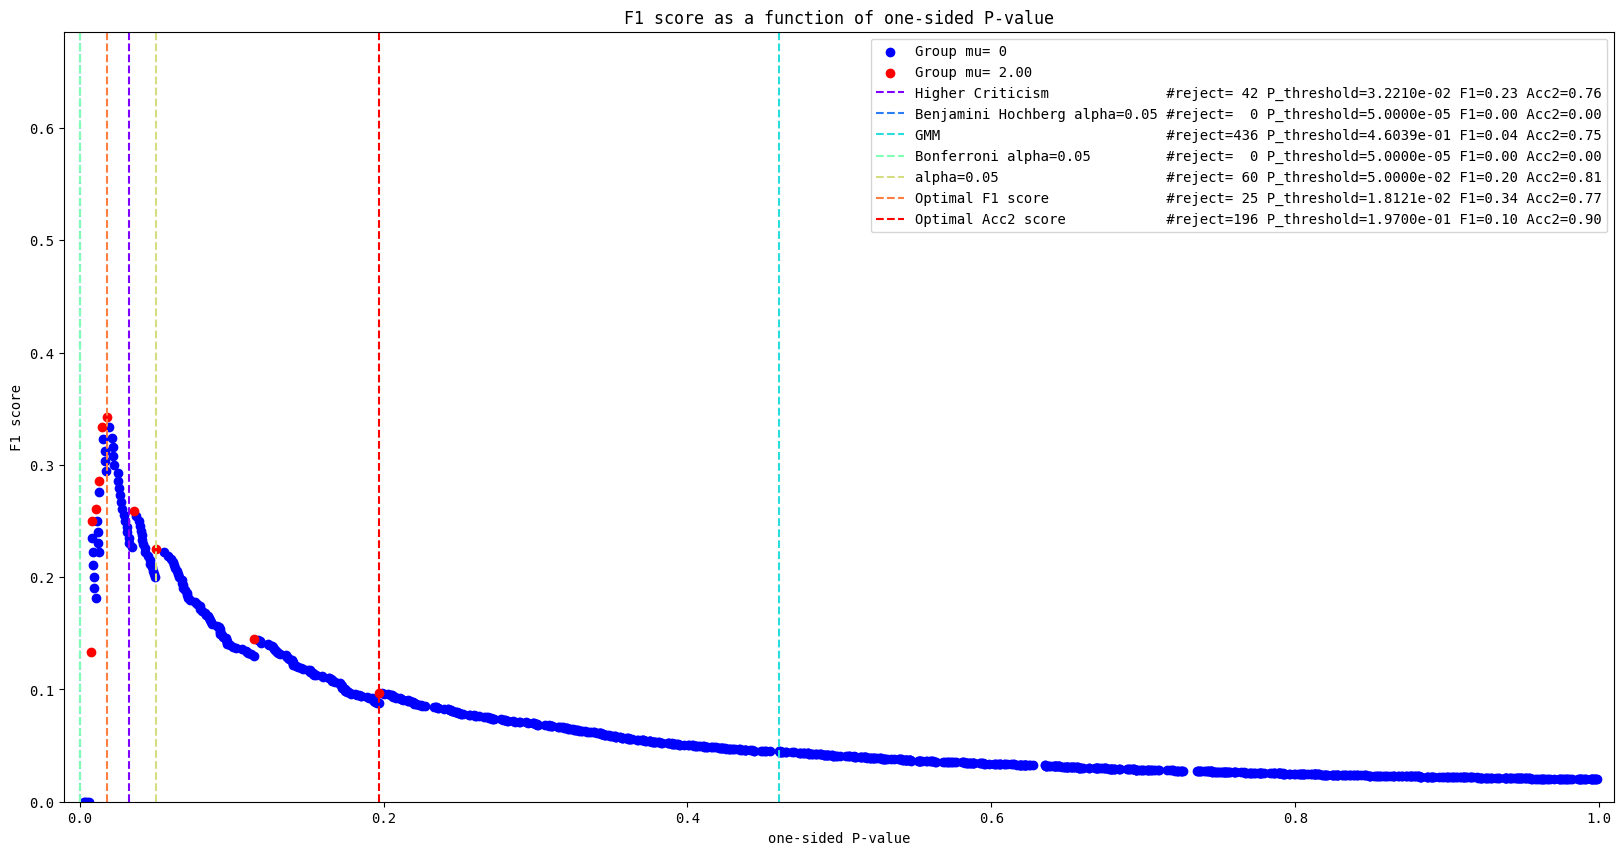

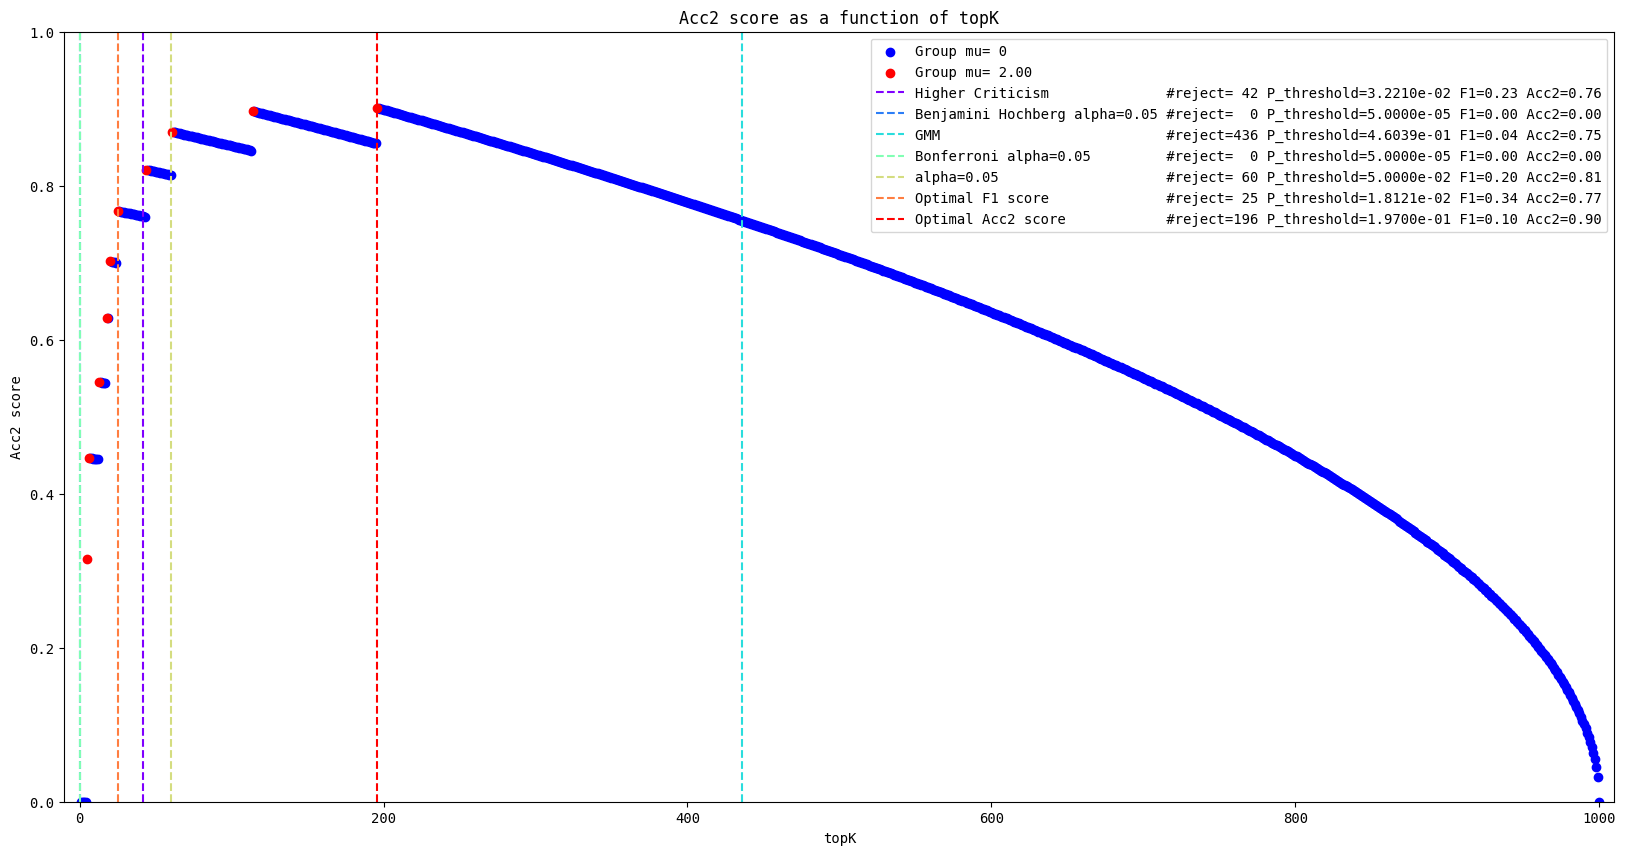

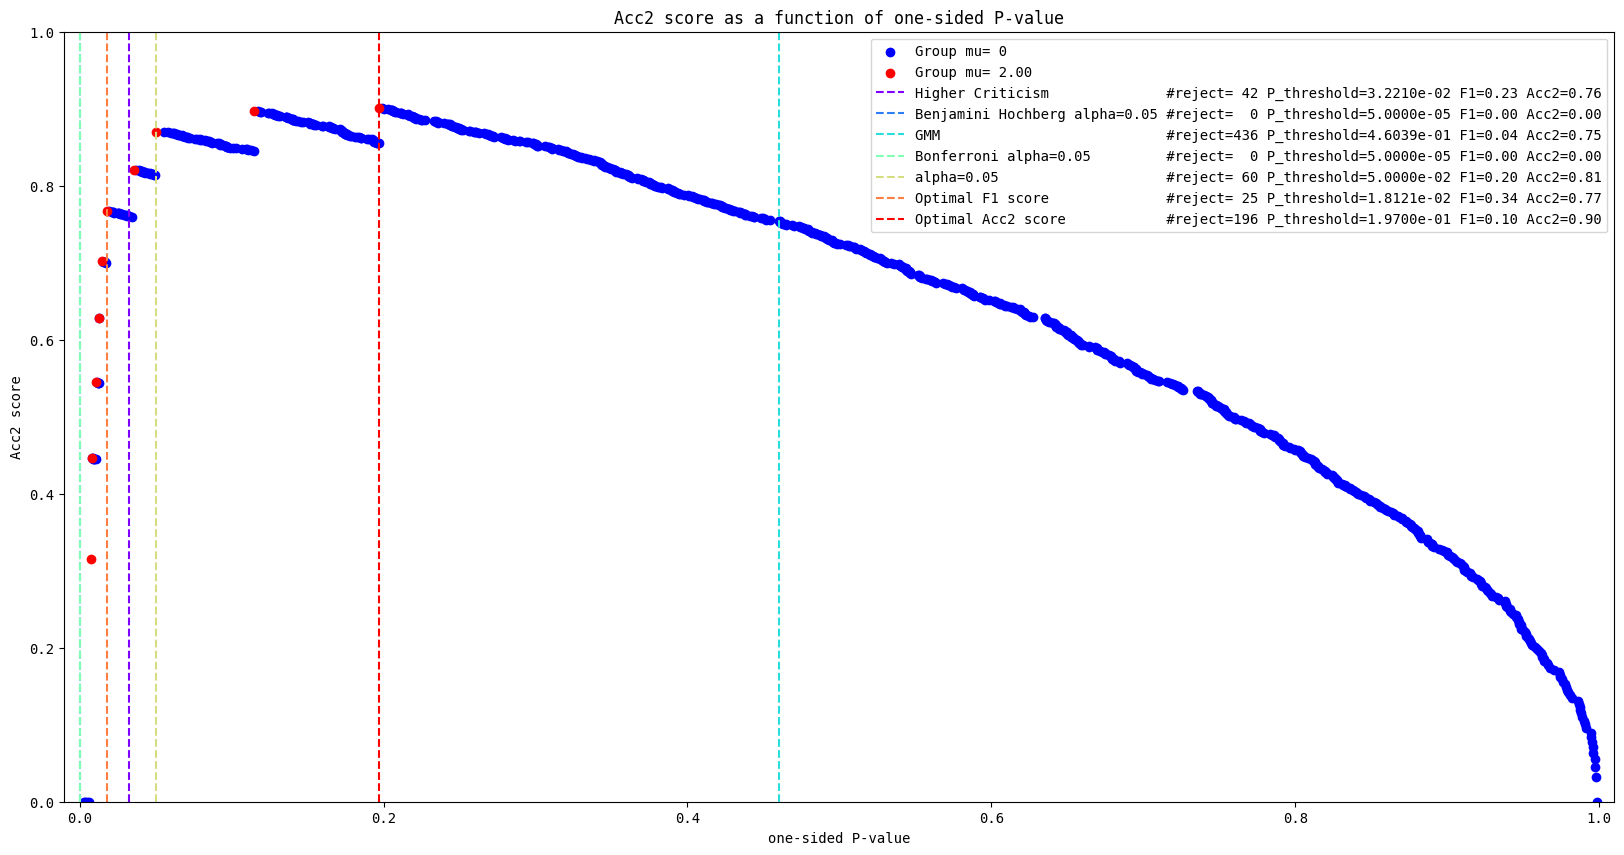

In [19]:
data.plot_f1_sorted_score()
data.plot_acc2_sorted_score()

In [20]:
N = 1000
rarity = np.arange(1,4.01,0.1)[::2]
mu = np.arange(0.5,5.01,0.1)[::2]
len_rarity = len(rarity)
len_mu = len(mu)
dummy_data = DataCreator(N=N, rarity=1, mu=1)
num_methods = len(dummy_data.non_optimal_methods) - 1  # remove using of alpha=p_value
num_metrics = 2
win_count = np.empty(shape=(num_metrics,num_methods), dtype=int)
selected_rejection_method = np.empty(shape=(num_metrics, len_rarity, len_mu), dtype=int)
monte_carlo = 10
x_tick_labels = []
y_tick_labels = []
for ind_rarity, ind_mu in tqdm(list(itertools.product(range(len_rarity),range(len_mu)))):
    r = rarity[ind_rarity]
    m = mu[ind_mu]
    win_count.fill(0)
    for seed in range(monte_carlo):
        dc = DataCreator(N=N, rarity=r, mu=m, seed=seed)
        f1_score = [m.f1_score_num_rejected for m in dc.all_methods[:num_methods]]
        acc2_score = [m.acc2_score_num_rejected for m in dc.all_methods[:num_methods]]
        ind_method_f1 = np.array(f1_score).argmax()
        ind_method_acc2 = np.array(acc2_score).argmax()
        win_count[0][ind_method_f1] += 1
        win_count[1][ind_method_acc2] += 1
        if ind_rarity >= len(y_tick_labels):
            y_tick_labels.append(f'{r:.2f}')
        if ind_mu >= len(x_tick_labels):
            x_tick_labels.append(f'{m:.2f}')
    for i in range(num_metrics):
        selected_rejection_method[i][ind_rarity][ind_mu] = win_count[i].argmax()


100%|██████████| 368/368 [1:50:38<00:00, 18.04s/it]


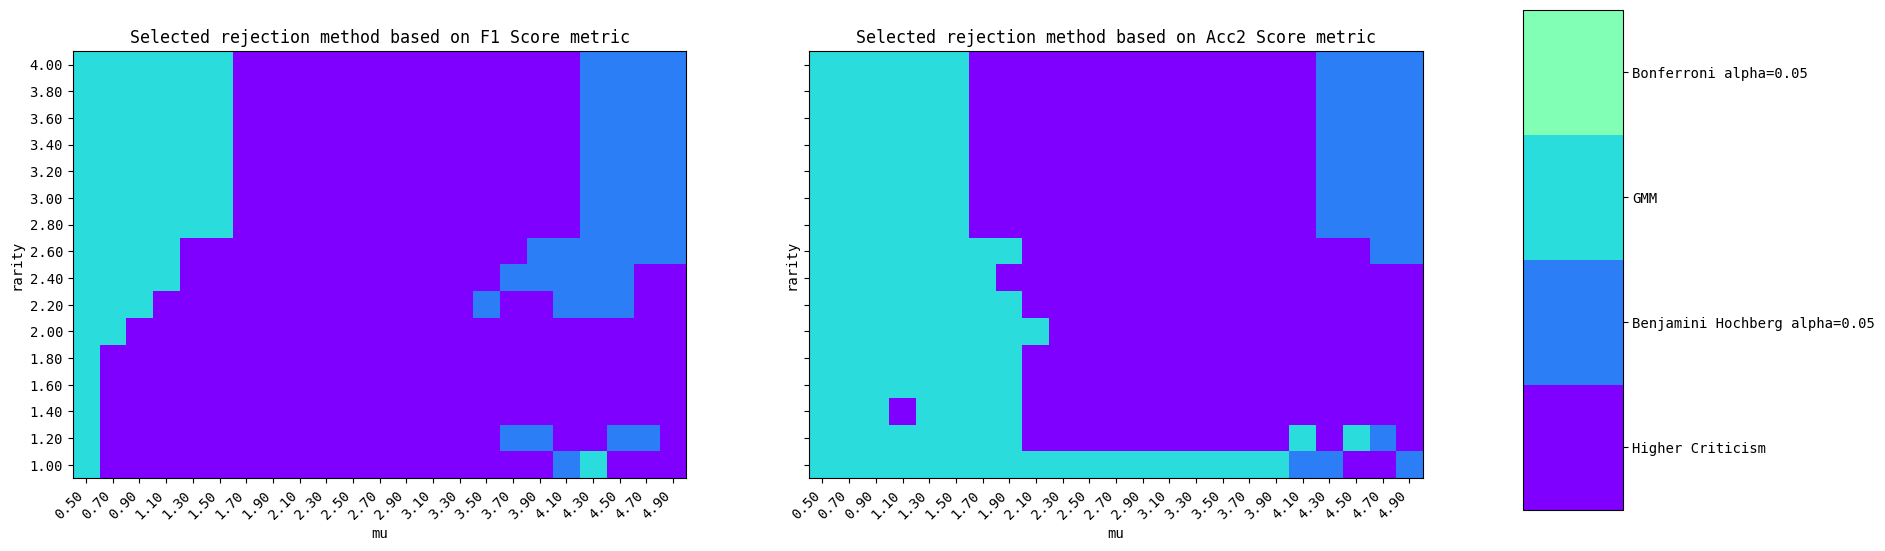

In [21]:
reversed_y = True
cmap = dummy_data.ListedColormap(num_methods)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
im = None
for ind_metrics, name_metrics in enumerate(['F1 Score', 'Acc2 Score']):
    ax = axs[ind_metrics]
    ax.set_title(f'Selected rejection method based on {name_metrics} metric')
    ax.set_xticks(np.arange(len_mu), labels=x_tick_labels, rotation=45, ha='right')
    ax.set_xlabel('mu')
    ax.set_yticks(np.arange(len_rarity), labels=reversed(y_tick_labels) if reversed_y else y_tick_labels)
    ax.set_ylabel('rarity')
    mat = selected_rejection_method[ind_metrics]
    if reversed_y:
        mat = mat[::-1]
    im = ax.imshow(mat, interpolation='nearest', vmin=-0.5, vmax=num_methods-0.5, cmap=cmap)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes((0.85, 0.25, 0.05, 0.5))
if im:
    cax = fig.colorbar(im, cax=cbar_ax, ticks=np.linspace(0, num_methods-1, num_methods))
    cax.set_ticklabels([n.name for n in dummy_data.non_optimal_methods[:num_methods]])